In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
%matplotlib inline

In [73]:
df = pd.read_csv('diabetes.csv')
df.head()
#Diabeter Pedigree: A function which scores likelihood of diabetes based on family history.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [74]:
print('Null values:\n',df.isnull().sum())
print('\n')
print('Duplicates:', df.duplicated().sum()) #There are no duplicates & null values in the dataset.

Null values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Duplicates: 0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [76]:
df.describe() #Glucose, Blood Pressure, Skin Thickness, Insulin and BMI have 0 values which are not possible.
#We will handle it later.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Data Overview
The dataset contains information about various health metrics. Initial inspection shows that columns like Glucose, Blood Pressure, and BMI contain zero values, which are physiologically impossible and will need handling.

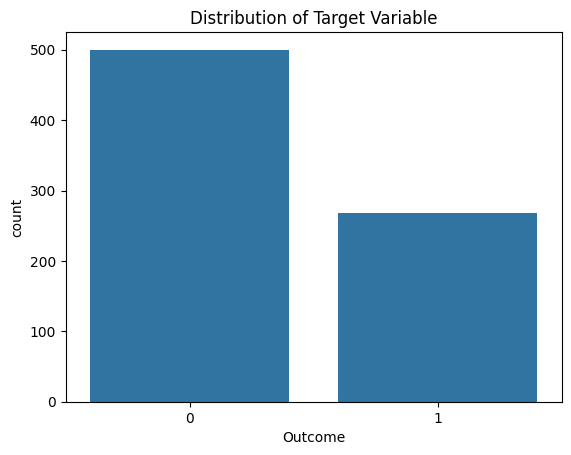

In [77]:
#Let's look at our target variable distribution.
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Target Variable')
plt.show()
#Dataset is a little imbalanced
# The ratio of imbalancing 2:1 we can look at f1score than accuracy for evaluation of our model.

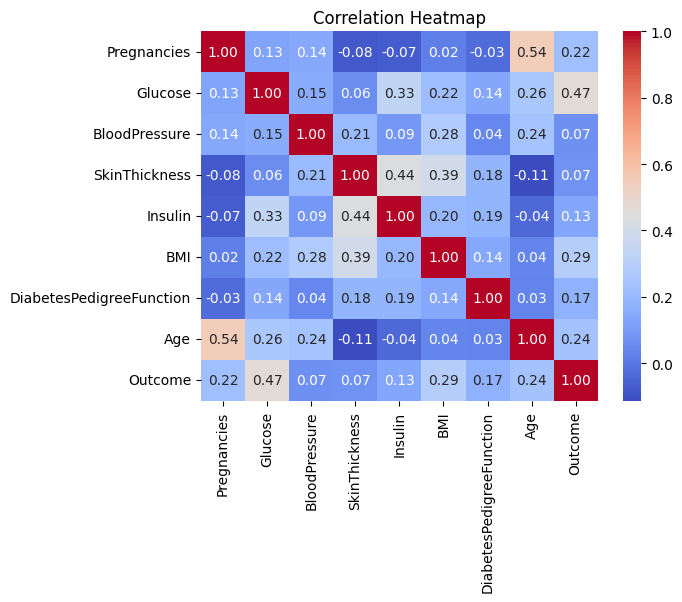

In [78]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm',fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
#Most highly correlated features with target is Glucose

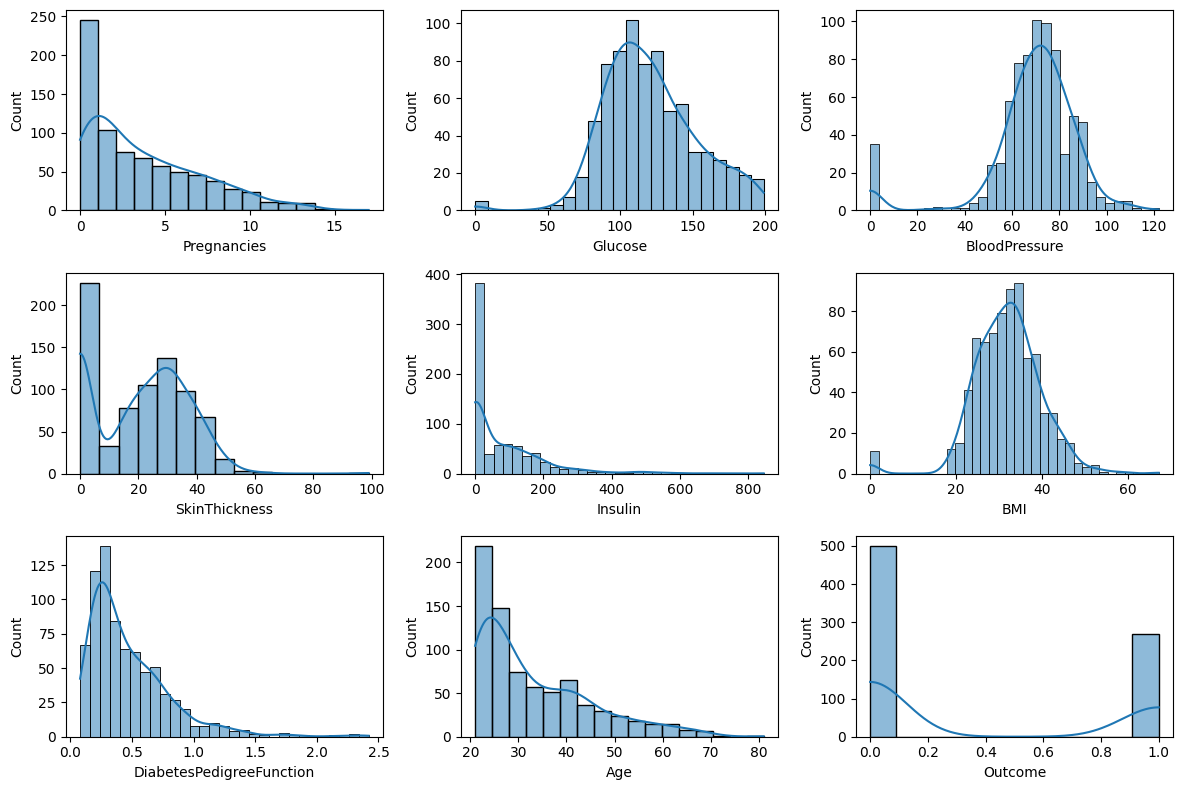

In [79]:
fig, ax = plt.subplots(3,3, figsize=(12,8))
ax = ax.flatten()
for i, column in enumerate(df.columns):
    sns.histplot(data=df, x=column, ax=ax[i],kde=True)

plt.tight_layout()
plt.show()

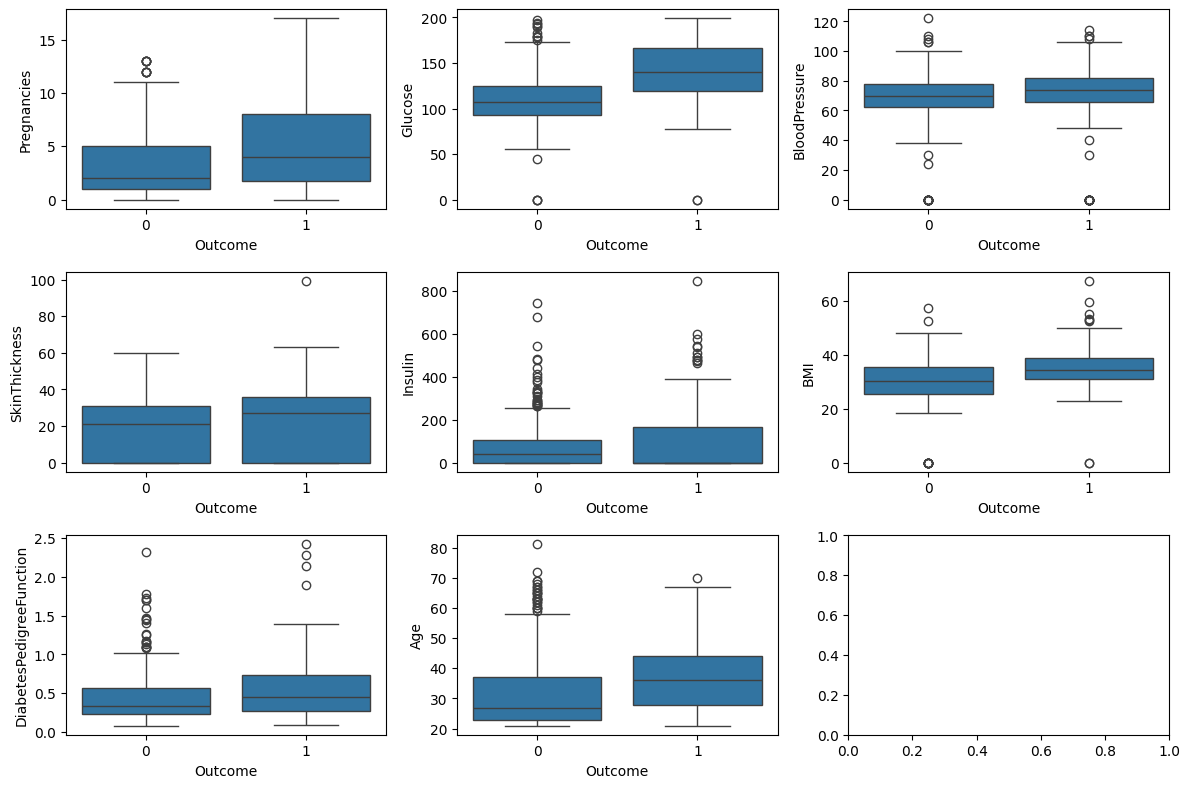

In [80]:
fig , axes = plt.subplots(3,3, figsize=(12,8))
axes = axes.flatten()
for i, column in enumerate(df.columns[:-1]):
    sns.boxplot(x='Outcome', y=column, data=df, ax=axes[i])
plt.tight_layout()
plt.show()

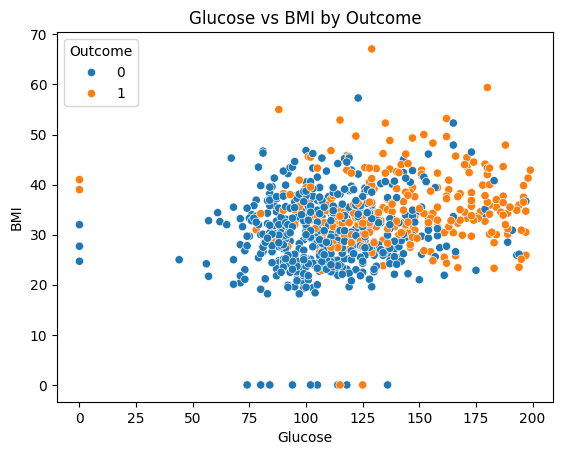

In [81]:
sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', data=df)
plt.title('Glucose vs BMI by Outcome')
plt.show()

### Visual Insights
The EDA reveals that **Glucose** and **BMI** are strongly correlated with the **Outcome**. The target class is slightly imbalanced, which suggests that accuracy might not be the best single metric for evaluation.

#### Now discuss, what we do about missing datas in the columns
Let's look at the rate of them compared to all data

In [82]:
columns_missing_values = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in columns_missing_values:
    zero_count = (df[column] == 0).sum()
    zero_percentage = (zero_count / len(df)) * 100
    print(f'{column}: {zero_count} zeros ({zero_percentage:.2f}%)')

#As we can see Skin Thickness and Insulin is the most missing values.
#We will create models with Insulin and without Insulin and compare the results
# Also I'll imputing missin values with median or mean according to their disturbition.



Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)


In [83]:
# Summary of imputation based on skewness
imputingTypes = {}
for column in columns_missing_values:
    skewness = df[column].skew()
    method = "mean" if abs(skewness) < 0.5 else "median"
    imputingTypes[column] = method
    print(f"{column}: {method}")

Glucose: mean
BloodPressure: median
SkinThickness: mean
Insulin: median
BMI: mean


In [84]:
imputingTypes

{'Glucose': 'mean',
 'BloodPressure': 'median',
 'SkinThickness': 'mean',
 'Insulin': 'median',
 'BMI': 'mean'}

In [85]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [87]:
for column in columns_missing_values:
    if imputingTypes[column] == "mean":
        impute_value = X_train[column].mean()
        print(f"Imputing {column} with mean: {impute_value:.2f}")
    else:
        impute_value = X_train[column].median()
        print(f"Imputing {column} with median: {impute_value:.2f}")
    
    X_train[column].replace(0, impute_value, inplace=True)
    X_test[column].replace(0, impute_value, inplace=True)

Imputing Glucose with mean: 120.91
Imputing BloodPressure with median: 72.00
Imputing SkinThickness with mean: 20.78
Imputing Insulin with median: 40.50
Imputing BMI with mean: 31.97


### Data Cleaning
Missing values (zeros) were imputed using the **Mean** for normally distributed columns and the **Median** for skewed columns. This process was performed separately on train and test sets to prevent data leakage.

In [88]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.819218,121.696474,72.140065,26.698620,97.794788,32.441954,0.477428,33.366450
std,3.314148,30.001473,12.275119,9.647076,94.879796,6.824359,0.330300,11.833438
min,0.000000,56.000000,24.000000,7.000000,15.000000,18.200000,0.084000,21.000000
25%,1.000000,99.000000,64.000000,20.776873,40.500000,27.625000,0.245000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,40.750000,32.300000,0.382500,29.000000
75%,6.000000,140.000000,80.000000,32.000000,130.000000,36.500000,0.639250,41.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,67.100000,2.329000,81.000000


In [89]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Feature Scaling
We used **RobustScaler** to handle potential outliers in the features. Scaling is essential for distance-based models like KNN and SVM.

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [91]:
models = {
    'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

In [92]:
def calculate_model_metrics(true,predicted):
    class_report = classification_report(true, predicted)
    conf_matrix = confusion_matrix(true, predicted)
    return class_report, conf_matrix

In [93]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_pred_train = model.predict(X_train_scaled) # Understanding overfitting & underfitting
    y_pred_test = model.predict(X_test_scaled)

    model_train_class_report, model_train_conf_matrix = calculate_model_metrics(y_train, y_pred_train)
    model_test_class_report, model_test_conf_matrix = calculate_model_metrics(y_test, y_pred_test)


    print(model_name)

    print('Evaluation on Training Set:')
    print(model_train_class_report)
    print('Confusion Matrix:')
    print(model_train_conf_matrix)
    print('---')
    print('Evaluation on Test Set:')
    print(model_test_class_report)
    print('Confusion Matrix:')
    print(model_test_conf_matrix)
    print('---')
    print('\n')

LogisticRegression
Evaluation on Training Set:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       400
           1       0.76      0.60      0.67       214

    accuracy                           0.79       614
   macro avg       0.78      0.75      0.76       614
weighted avg       0.79      0.79      0.79       614

Confusion Matrix:
[[360  40]
 [ 86 128]]
---
Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.59      0.48      0.53        54

    accuracy                           0.70       154
   macro avg       0.67      0.65      0.66       154
weighted avg       0.69      0.70      0.69       154

Confusion Matrix:
[[82 18]
 [28 26]]
---


KNN
Evaluation on Training Set:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       400
           1       0.79      0.66      0.72   

### Model Comparison
Several classifiers were trained and compared. **AdaBoost** and **RandomForest** showed the best overall performance in terms of accuracy. However, in medical diagnostics, **Recall** (minimizing false negatives) is often more critical than precision.

In [98]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100,125,150,175],
    'learning_rate': [0.01, 0.05, 0.1,0.5, 1]
}
grid_search = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, cv=5,n_jobs=-1,verbose=1)
grid_search.fit(X_train_scaled, y_train)
y_grid_pred = grid_search.predict(X_test_scaled)
print(grid_search.best_params_) 
print(classification_report(y_test, y_grid_pred))
print(confusion_matrix(y_test, y_grid_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'learning_rate': 0.5, 'n_estimators': 125}
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       100
           1       0.69      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.73      0.70      0.71       154
weighted avg       0.75      0.75      0.74       154

[[87 13]
 [25 29]]


### Hyperparameter Optimization
**GridSearchCV** was used to find the best parameters for AdaBoost. While the improvement was marginal, it ensures the model is better generalized to unseen data.

### Hyperparameter Tuning 
We did hyperparameter tuning but it doesn't change result too much.

In [128]:
#Recall is much more important than precision in health cases
#So we will decrease threshold to increase recall
model = AdaBoostClassifier(n_estimators=125, learning_rate=0.5)
model.fit(X_train_scaled, y_train)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.45
y_pred_threshold = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_test, y_pred_threshold))
print(confusion_matrix(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       100
           1       0.64      0.78      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.78      0.77      0.77       154

[[76 24]
 [12 42]]


### Threshold Adjustment
To prioritize **Recall**, we lowered the classification threshold to **0.45**. This captures more potential diabetic cases (positive class) at the cost of some additional false positives.

###
Now let's try dropping the column of insulin

In [105]:
X_train_dropped = X_train.drop(columns=['Insulin'],axis=1)
X_test_dropped = X_test.drop(columns=['Insulin'],axis=1)

In [107]:
X_test_dropped

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
44,7,159.0,64,20.776873,27.40000,0.294,40
672,10,68.0,106,23.000000,35.50000,0.285,47
700,2,122.0,76,27.000000,35.90000,0.483,26
630,7,114.0,64,20.776873,27.40000,0.732,34
81,2,74.0,72,20.776873,31.97329,0.102,22
...,...,...,...,...,...,...,...
32,3,88.0,58,11.000000,24.80000,0.267,22
637,2,94.0,76,18.000000,31.60000,0.649,23
593,2,82.0,52,22.000000,28.50000,1.699,25
425,4,184.0,78,39.000000,37.00000,0.264,31


In [108]:
X_train_drop_scaled = scaler.fit_transform(X_train_dropped)
X_test_drop_scaled = scaler.transform(X_test_dropped)

In [109]:
for model_name, model in models.items():
    model.fit(X_train_drop_scaled, y_train)

    y_pred_test = model.predict(X_test_drop_scaled)

    model_test_class_report, model_test_conf_matrix = calculate_model_metrics(y_test, y_pred_test)


    print(model_name)

    print('---')
    print('Evaluation on Test Set:')
    print(model_test_class_report)
    print('Confusion Matrix:')
    print(model_test_conf_matrix)
    print('---')
    print('\n')

LogisticRegression
---
Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.59      0.48      0.53        54

    accuracy                           0.70       154
   macro avg       0.67      0.65      0.66       154
weighted avg       0.69      0.70      0.69       154

Confusion Matrix:
[[82 18]
 [28 26]]
---


KNN
---
Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       100
           1       0.61      0.57      0.59        54

    accuracy                           0.72       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.72      0.72       154

Confusion Matrix:
[[80 20]
 [23 31]]
---


SVC
---
Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       100
           1       0.66      0.54      0

### Removing High-Null Features
Dropping the **Insulin** column (which had many zero values) actually led to a slight improvement in model performance, suggesting that imputed values for Insulin may have introduced more noise than signal.

### When we drop insulin we get slightly better performance 0.75 to 0.76 in accuracy

In [121]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50,100,150,200],
    'learning_rate': [0.001, 0.01, 0.1, 1]
}
grid_search = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, cv=5,n_jobs=-1,verbose=1)
grid_search.fit(X_train_drop_scaled, y_train)
y_grid_pred = grid_search.predict(X_test_drop_scaled)
print(grid_search.best_params_) 
print(classification_report(y_test, y_grid_pred))
print(confusion_matrix(y_test, y_grid_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'learning_rate': 1, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.68      0.59      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.73       154
weighted avg       0.75      0.76      0.76       154

[[85 15]
 [22 32]]


In [127]:
#Recall is much more important than precision in health cases
#So we will decrease threshold to increase recall
model = AdaBoostClassifier(n_estimators=50, learning_rate=1)
model.fit(X_train_drop_scaled, y_train)
y_pred_proba = model.predict_proba(X_test_drop_scaled)[:, 1]
threshold = 0.45
y_pred_threshold = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_test, y_pred_threshold))
print(confusion_matrix(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       100
           1       0.63      0.80      0.70        54

    accuracy                           0.77       154
   macro avg       0.75      0.77      0.76       154
weighted avg       0.79      0.77      0.77       154

[[75 25]
 [11 43]]


ROC AUC Skoru: 0.8191


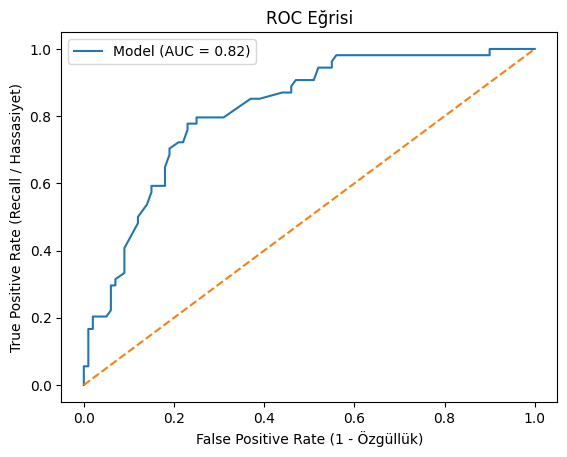

In [124]:
from sklearn.metrics import roc_auc_score, roc_curve

# 1. Modelinden olasılıkları al (predict_proba)
# Genelde [:, 1] diyabet olma (pozitif sınıf) olasılığını verir
y_probs = model.predict_proba(X_test_drop_scaled)[:, 1] 

# 2. AUC Skorunu Hesapla
auc_score = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Skoru: {auc_score:.4f}")

# 3. ROC Eğrisini Çizdir
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.plot(fpr, tpr, label=f'Model (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--') # Rastgele tahmin çizgisi
plt.xlabel('False Positive Rate (1 - Özgüllük)')
plt.ylabel('True Positive Rate (Recall / Hassasiyet)')
plt.title('ROC Eğrisi')
plt.legend()
plt.show()


### Final Conclusion
The ROC curve and AUC score confirm that the **AdaBoost** model has good discriminative power. By balancing imputation strategies, feature selection (dropping Insulin), and threshold tuning, we achieved a robust model for predicting diabetes risk.